This script processes and analyzes customer feedback for different food recipes. It uses Named Entity Recognition (NER) to identify food names in customer reviews and a sentiment analysis function to classify these reviews as either 'good' or 'bad'. The script then aggregates the sentiment analysis results for each food item, resulting in a dictionary where each key is a food name and each value is another dictionary containing the counts of 'good' and 'bad' feedback. The aggregated results are printed out for further interpretation and analysis


In [ ]:
import pandas as pd
import re
import random
import spacy
from spacy.util import minibatch, compounding
import warnings
import matplotlib.pyplot as plt
from spacy.training.example import Example
from spacy.training import offsets_to_biluo_tags

### 1. Data Preparation
The script starts by loading a CSV file containing recipe details. It then cleans the data by removing special characters and converting all text to lowercase. It also filters out food items with more than three words and removes duplicates. The script then creates a bar plot to visualize the number of words in the food entities.

In [3]:
food_df = pd.read_csv("database/01_Recipe_Details.csv")
food_df.head()

,Recipe ID,Title,Source,Cuisine
0,1,5 spice vegetable fried rice,TARLA_DALAL,Indian Subcontinent
1,2,aachar aaloo,TARLA_DALAL,Indian Subcontinent
2,3,aadu lassan keri nu athanu,TARLA_DALAL,Indian Subcontinent
3,4,aaloo kofta,TARLA_DALAL,Indian Subcontinent
4,5,aaloo tamatar subzi,TARLA_DALAL,Indian Subcontinent


In [6]:
food_df["Title"].size
# diaqualify foods with special characters, lowercase and extract results from "Title" column
foods = food_df[food_df["Title"].str.contains("[^a-zA-Z ]") == False]["Title"].apply(lambda food: food.lower())
# filter out foods with more than 3 words, drop any duplicates
foods = foods.drop_duplicates()


In [8]:
# print the remaining size
foods.size

32140

In [7]:

# find one-worded, two-worded and three-worded foods
one_worded_foods = foods[foods.str.split().apply(len) == 1]
two_worded_foods = foods[foods.str.split().apply(len) == 2]
three_worded_foods = foods[foods.str.split().apply(len) == 3]
four_worded_foods = foods[foods.str.split().apply(len) == 4]
five_worded_foods = foods[foods.str.split().apply(len) == 5]
six_worded_foods = foods[foods.str.split().apply(len) == 6]
seven_worded_foods = foods[foods.str.split().apply(len) >= 7]

<BarContainer object of 7 artists>

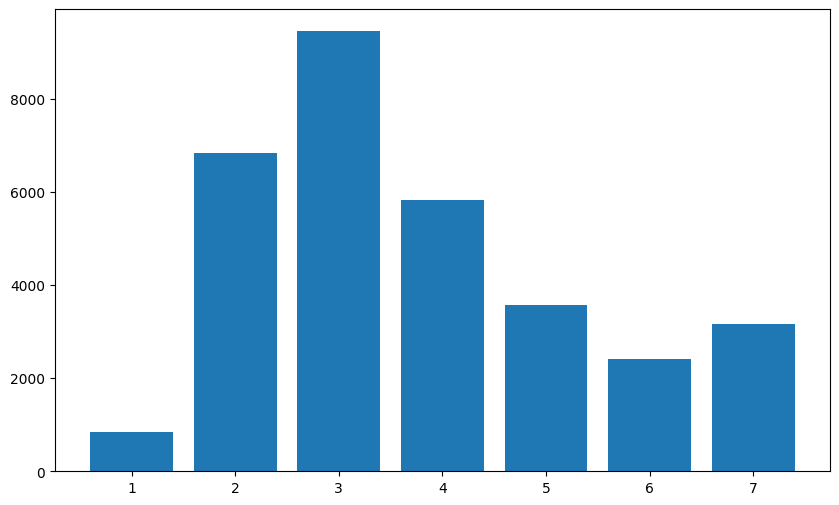

In [9]:
# create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([1, 2, 3, 4, 5, 6, 7],
       [one_worded_foods.size, two_worded_foods.size, three_worded_foods.size, four_worded_foods.size,
        five_worded_foods.size,
        six_worded_foods.size,
        seven_worded_foods.size])

In [10]:
# label the x-axis instances
ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(["one", "two", "three", 'four', 'five', 'six', 'seven'])

[Text(1, 0, 'one'),
 Text(2, 0, 'two'),
 Text(3, 0, 'three'),
 Text(4, 0, 'four'),
 Text(5, 0, 'five'),
 Text(6, 0, 'six'),
 Text(7, 0, 'seven')]

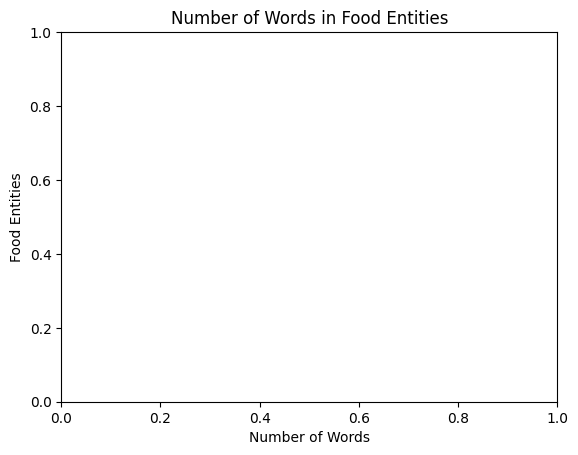

In [12]:
# set the title and the xy-axis labels
plt.title("Number of Words in Food Entities")
plt.xlabel("Number of Words")
plt.ylabel("Food Entities")
plt.show()

### 2. Data Splitting
splits the food items into training and testing data. It ensures that the number of one-word, two-word, and three-word food items are balanced in both the training and testing datasets.

In [13]:
# total number of foods
total_num_foods = round(one_worded_foods.size / 45 * 100)

# shuffle the 2-worded and 3-worded foods since we'll be slicing them
two_worded_foods = two_worded_foods.sample(frac=1)
three_worded_foods = three_worded_foods.sample(frac=1)
four_worded_foods = four_worded_foods.sample(frac=1)
five_worded_foods = five_worded_foods.sample(frac=1)
six_worded_foods = six_worded_foods.sample(frac=1)
seven_worded_foods = seven_worded_foods.sample(frac=1)

In [14]:
# append the foods together
foods = one_worded_foods.append(two_worded_foods[:round(total_num_foods * 0.30)]).append(
    three_worded_foods[:round(total_num_foods * 0.25)]).append(
    four_worded_foods[:round(total_num_foods * 0.25)]).append(five_worded_foods[:round(total_num_foods * 0.25)]).append(
    six_worded_foods[:round(total_num_foods * 0.25)]).append(seven_worded_foods[:round(total_num_foods * 0.25)])

C:\Users\shira\AppData\Local\Temp\ipykernel_16776\271895241.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  foods = one_worded_foods.append(two_worded_foods[:round(total_num_foods * 0.30)]).append(
C:\Users\shira\AppData\Local\Temp\ipykernel_16776\271895241.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  foods = one_worded_foods.append(two_worded_foods[:round(total_num_foods * 0.30)]).append(
C:\Users\shira\AppData\Local\Temp\ipykernel_16776\271895241.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  three_worded_foods[:round(total_num_foods * 0.25)]).append(
C:\Users\shira\AppData\Local\Temp\ipykernel_16776\271895241.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in

In [16]:
# print the resulting sizes
for i in range(3):
    print(f"{i + 1}-worded food entities:", foods[foods.str.split().apply(len) == i + 1].size)
food_templates = [
    "I ate my {}",
    "I'm eating a {}",
    "I just ate a {}",
    "I only ate the {}",
    "I'm done eating a {}",
    "I've already eaten a {}",
    "I just finished my {}",
    "When I was having lunch I ate a {}",
    "I had a {} and a {} today",
    "I ate a {} and a {} for lunch",
    "I made a {} and {} for lunch",
    "I ate {} and {}",
    "today I ate a {} and a {} for lunch",
    "I had {} with my husband last night",
    "I brought you some {} on my birthday",
    "I made {} for yesterday's dinner",
    "last night, a {} was sent to me with {}",
    "I had {} yesterday and I'd like to eat it anyway",
    "I ate a couple of {} last night",
    "I had some {} at dinner last night",
    "Last night, I ordered some {}",
    "I made a {} last night",
    "I had a bowl of {} with {} and I wanted to go to the mall today",
    "I brought a basket of {} for breakfast this morning",
    "I had a bowl of {}",
    "I ate a {} with {} in the morning",
    "I made a bowl of {} for my breakfast",
    "There's {} for breakfast in the bowl this morning",
    "This morning, I made a bowl of {}",
    "I decided to have some {} as a little bonus",
    "I decided to enjoy some {}",
    "I've decided to have some {} for dessert",
    "I had a {}, a {} and {} at home",
    "I took a {}, {} and {} on the weekend",
    "I ate a {} with {} and {} just now",
    "Last night, I ate an {} with {} and {}",
    "I tasted some {}, {} and {} at the office",
    "There's a basket of {}, {} and {} that I consumed",
    "I devoured a {}, {} and {}",
    "I've already had a bag of {}, {} and {} from the fridge"
]

1-worded food entities: 848
2-worded food entities: 565
3-worded food entities: 471


In [18]:
# create dictionaries to store the generated food combinations. one_food != one_worded_food. one_food == "barbecue sauce", one_worded_food == "sauce"
TRAIN_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

TEST_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

In [20]:
# one_food, two_food, and three_food combinations will be limited to 167 sentences
FOOD_SENTENCE_LIMIT = 167
# helper function for deciding what dictionary and subsequent array to append the food sentence on to
def get_food_data(count):
    return {
        1: TRAIN_FOOD_DATA["one_food"] if len(TRAIN_FOOD_DATA["one_food"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA[
            "one_food"],
        2: TRAIN_FOOD_DATA["two_foods"] if len(TRAIN_FOOD_DATA["two_foods"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA[
            "two_foods"],
        3: TRAIN_FOOD_DATA["three_foods"] if len(TRAIN_FOOD_DATA["three_foods"]) < FOOD_SENTENCE_LIMIT else
        TEST_FOOD_DATA["three_foods"],
    }[count]



In [21]:
# the pattern to replace from the template sentences
pattern_to_replace = "{}"

# shuffle the data before starting
foods = foods.sample(frac=1)

# the count that helps us decide when to break from the for loop
food_entity_count = foods.size - 1


### 3. Sentence Generation
generates sentences using predefined templates and the food items from the training data. These sentences are used to train the NER model.

In [22]:

# start the while loop, ensure we don't get an index out of bounds error
while food_entity_count >= 2:
    entities = []

    # pick a random food template
    sentence = food_templates[random.randint(0, len(food_templates) - 1)]

    # find out how many braces "{}" need to be replaced in the template
    matches = re.findall(pattern_to_replace, sentence)

    # for each brace, replace with a food entity from the shuffled food data
    for match in matches:
        food = foods.iloc[food_entity_count]
        food_entity_count -= 1

        # replace the pattern, but then find the match of the food entity we just inserted
        sentence = sentence.replace(match, food, 1)
        match_span = re.search(food, sentence).span()

        # use that match to find the index positions of the food entity in the sentence, append
        entities.append((match_span[0], match_span[1], "FOOD"))

    # append the sentence and the position of the entities to the correct dictionary and array
    get_food_data(len(matches)).append((sentence, {"entities": entities}))

### 4. Model Training
The script uses the SpaCy library to train the NER model. It adds a new label "FOOD" to the NER model and trains the model using the generated sentences

In [24]:
import spacy.cli
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [32]:
for key in TEST_FOOD_DATA:
    print("{} {} items: {}".format(len(TEST_FOOD_DATA[key]), key, TEST_FOOD_DATA[key][0]))
# read in the revision data 
npr_df = pd.read_csv("database/dataset_instagram-post.csv", encoding='latin-1')

npr_df.head()

1214 one_food items: ('Last night, I ordered some strawberry avocado salad', {'entities': [(27, 51, 'FOOD')]})
303 two_foods items: ('I ate king burger and swallow nests', {'entities': [(6, 17, 'FOOD'), (22, 35, 'FOOD')]})
315 three_foods items: ("There's a basket of mandelbread, tan and light tuscan garlic chicken that I consumed", {'entities': [(20, 31, 'FOOD'), (33, 36, 'FOOD'), (41, 68, 'FOOD')]})


,caption,childPosts/0/alt,childPosts/0/caption,childPosts/0/commentsCount,childPosts/0/dimensionsHeight,childPosts/0/dimensionsWidth,childPosts/0/displayUrl,childPosts/0/firstComment,childPosts/0/id,childPosts/0/likesCount,...,taggedUsers/1/is_verified,taggedUsers/1/profile_pic_url,taggedUsers/1/username,timestamp,type,url,videoDuration,videoPlayCount,videoUrl,videoViewCount
0,Never throw away half a can of tomato paste or...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2023-04-24T15:11:42.000Z,Video,https://www.instagram.com/p/CrbGVw3gnpv/,21.084,46359.0,https://instagram.fltn3-2.fna.fbcdn.net/v/t66....,13786.0
1,@oliviamackmccool started making this breakfas...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2023-01-01T19:10:48.000Z,Video,https://www.instagram.com/p/Cm4jzpfI60S/,21.666,2793628.0,https://instagram.fanf3-1.fna.fbcdn.net/o1/v/t...,1975762.0
2,"It's â Coffee Week â over here at Food52, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2023-04-24T18:01:12.000Z,Image,https://www.instagram.com/p/CrbZ4_ip1zF/,NaN,NaN,NaN,NaN
3,These Hoisin Mushroom Gua Baos from @thefoodie...,NaN,NaN,0.0,1350.0,1080.0,https://instagram.ftpa1-1.fna.fbcdn.net/v/t51....,NaN,3.090000e+18,NaN,...,NaN,NaN,NaN,2023-04-24T02:00:25.000Z,Sidecar,https://www.instagram.com/p/CrZr73gIgQ0/,NaN,NaN,NaN,NaN
4,"For your next beach day, barbecue, or afternoo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2023-04-24T13:00:50.000Z,Image,https://www.instagram.com/p/Cra3hA9Oc_k/,NaN,NaN,NaN,NaN


In [25]:
nlp = spacy.load("en_core_web_lg")

In [28]:
revision_texts = []

In [33]:
# convert the articles to spacy objects to better identify the sentences. Disabled unneeded components.
for doc in nlp.pipe(npr_df["caption"], batch_size=30, disable=["tagger", "ner"]):
    for sentence in doc.sents:
        if 40 < len(sentence.text) < 80:
            # some of the sentences had excessive whitespace in between words, so we're trimming that
            revision_texts.append(" ".join(re.split("\s+", sentence.text, flags=re.UNICODE)))
revisions = []
# Use the existing spaCy model to predict the entities, then append them to revision
for doc in nlp.pipe(revision_texts, batch_size=50, disable=["tagger", "parser"]):

    # don't append sentences that have no entities
    if len(doc.ents) > 0:
        revisions.append((doc.text, {"entities": [(e.start_char, e.end_char, e.label_) for e in doc.ents]}))
# print an example of the revision sentence
print(revisions[0][0])

# print an example of the revision data
print(revisions[0][1])


C:\Users\shira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


", "Fold in remaining 2 cups of blueberries.
{'entities': [(4, 8, 'WORK_OF_ART'), (22, 23, 'CARDINAL')]}


In [34]:
# create arrays to store the revision data
TRAIN_REVISION_DATA = []
TEST_REVISION_DATA = []

# create dictionaries to keep count of the different entities
TRAIN_ENTITY_COUNTER = {}
TEST_ENTITY_COUNTER = {}

# This will help distribute the entities (i.e. we don't want 1000 PERSON entities, but only 80 ORG entities)
REVISION_SENTENCE_SOFT_LIMIT = 100

In [35]:
# helper function for incrementing the revision counters
def increment_revision_counters(entity_counter, entities):
    for entity in entities:
        label = entity[2]
        if label in entity_counter:
            entity_counter[label] += 1
        else:
            entity_counter[label] = 1


random.shuffle(revisions)

In [36]:
for revision in revisions:
    # get the entities from the revision sentence
    entities = revision[1]["entities"]

    # simple hack to make sure spaCy entities don't get too one-sided
    should_append_to_train_counter = 0
    for _, _, label in entities:
        if label in TRAIN_ENTITY_COUNTER and TRAIN_ENTITY_COUNTER[label] > REVISION_SENTENCE_SOFT_LIMIT:
            should_append_to_train_counter -= 1
        else:
            should_append_to_train_counter += 1

    # simple switch for deciding whether to append to train data or test data
    if should_append_to_train_counter >= 0:
        TRAIN_REVISION_DATA.append(revision)
        increment_revision_counters(TRAIN_ENTITY_COUNTER, entities)
    else:
        TEST_REVISION_DATA.append(revision)
        increment_revision_counters(TEST_ENTITY_COUNTER, entities)
# combine the food training data
TRAIN_FOOD_DATA_COMBINED = TRAIN_FOOD_DATA["one_food"] + TRAIN_FOOD_DATA["two_foods"] + TRAIN_FOOD_DATA["three_foods"]

In [37]:
# print the length of the food training data
print("FOOD", len(TRAIN_FOOD_DATA_COMBINED))

FOOD 501


In [38]:
# print the length of the revision training data
print("REVISION", len(TRAIN_REVISION_DATA))

REVISION 1615


In [39]:
# join and print the combined length
TRAIN_DATA = TRAIN_REVISION_DATA + TRAIN_FOOD_DATA_COMBINED
print("COMBINED", len(TRAIN_DATA))
# add NER to the pipeline and the new label
ner = nlp.get_pipe("ner")
ner.add_label("FOOD")

COMBINED 2116


1

In [40]:
# get the names of the components we want to disable during training
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

In [41]:
# start the training loop, only training NER
epochs = 30
optimizer = nlp.resume_training()
with nlp.disable_pipes(*other_pipes), warnings.catch_warnings():
    warnings.filterwarnings("once", category=UserWarning, module='spacy')
    sizes = compounding(1.0, 4.0, 1.001)
    # Batch up the examples using spaCy's minibatch
    for epoch in range(epochs):
        examples = []
        random.shuffle(TRAIN_DATA)
        batches = minibatch(TRAIN_DATA, size=sizes)
        losses = {}
        for batch in batches:
            for text, annotations in batch:
                doc = nlp.make_doc(text)
                tags = offsets_to_biluo_tags(doc, annotations['entities'])
                if '-' in tags:
                    continue
                annotations['tags'] = tags
                example = Example.from_dict(doc, annotations)
                examples.append(example)
            nlp.update(examples, sgd=optimizer, drop=0.35, losses=losses)
            examples = []
        print("Losses ({}/{})".format(epoch + 1, epochs), losses)
spacy.displacy.render(nlp("Apple is looking at buying U.K. startup for $1 billion"), style="ent")
# display sentences involving target entity
spacy.displacy.render(nlp("I had a hamburger and chips for lunch today."), style="ent")
spacy.displacy.render(nlp("I decided to have chocolate ice cream as a little treat for myself."), style="ent")
spacy.displacy.render(nlp("I ordered basmati rice, leaf spinach and cheese from Tesco yesterday"), style="ent")

Losses (1/30) {'ner': 3679.7745317131876}
Losses (2/30) {'ner': 2757.1202854877565}
Losses (3/30) {'ner': 2275.717699868621}
Losses (4/30) {'ner': 2115.7466520974804}
Losses (5/30) {'ner': 1897.3696231015103}
Losses (6/30) {'ner': 1791.8102572492628}
Losses (7/30) {'ner': 1613.3587011205445}
Losses (8/30) {'ner': 1612.241379611464}
Losses (9/30) {'ner': 1362.2464820147352}
Losses (10/30) {'ner': 1340.5613810941215}
Losses (11/30) {'ner': 1281.6345872898091}
Losses (12/30) {'ner': 1330.4415245276643}
Losses (13/30) {'ner': 1199.551791175148}
Losses (14/30) {'ner': 1177.244048007223}
Losses (15/30) {'ner': 1098.9472105510633}
Losses (16/30) {'ner': 1093.903232491754}
Losses (17/30) {'ner': 1066.8039222110044}
Losses (18/30) {'ner': 1037.18185221969}
Losses (19/30) {'ner': 880.4147046805683}
Losses (20/30) {'ner': 1001.9101958214583}
Losses (21/30) {'ner': 940.117143145171}
Losses (22/30) {'ner': 880.0274930009408}
Losses (23/30) {'ner': 882.2247136389259}
Losses (24/30) {'ner': 874.85664

C:\Users\shira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\spacy\displacy\__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [42]:
# dictionary to hold our evaluation data
food_evaluation = {
    "one_food": {
        "correct": 0,
        "total": 0,
    },
    "two_foods": {
        "correct": 0,
        "total": 0
    },
    "three_foods": {
        "correct": 0,
        "total": 0
    }
}

word_evaluation = {
    "1_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "2_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "3_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "4_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "5_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "6_worded_foods": {
        "correct": 0,
        "total": 0
    }, "7_worded_foods": {
        "correct": 0,
        "total": 0
    }
}

In [43]:
# loop over data from our test food set (3 keys in total)
for key in TEST_FOOD_DATA:
    foods = TEST_FOOD_DATA[key]

    for food in foods:
        # extract the sentence and correct food entities according to our test data
        sentence = food[0]
        entities = food[1]["entities"]

        # for each entity, use our updated model to make a prediction on the sentence
        for entity in entities:
            doc = nlp(sentence)
            correct_text = sentence[entity[0]:entity[1]]
            n_worded_food = len(correct_text.split())
            if n_worded_food > 7:
                n_worded_food = 7
            # if we find that there's a match for predicted entity and predicted text, increment correct counters
            for ent in doc.ents:
                if ent.label_ == entity[2] and ent.text == correct_text:
                    food_evaluation[key]["correct"] += 1
                    if n_worded_food > 0:

                        if not word_evaluation.get(f"{n_worded_food}_worded_foods"):
                            word_evaluation[f"{n_worded_food}_worded_foods"] = {"correct": 0, "total": 0}

                        word_evaluation[f"{n_worded_food}_worded_foods"]["correct"] += 1

                    # this break is important, ensures that we're not double counting on a correct match
                    break

            #  increment total counters after each entity loop
            food_evaluation[key]["total"] += 1
            if n_worded_food > 0:
                word_evaluation[f"{n_worded_food}_worded_foods"]["total"] += 1
for key in word_evaluation:
    correct = word_evaluation[key]["correct"]
    total = word_evaluation[key]["total"]
    print(f"{key}: {correct / (total or 0.1) * 100:.2f}%")

food_total_sum = 0
food_correct_sum = 0

print("---")
for key in food_evaluation:
    correct = food_evaluation[key]["correct"]
    total = food_evaluation[key]["total"]

    food_total_sum += total
    food_correct_sum += correct

    print(f"{key}: {correct / total * 100:.2f}%")
print(f"\nTotal: {food_correct_sum / food_total_sum * 100:.2f}%")

# dictionary which will be populated with the entities and result information
entity_evaluation = {}

1_worded_foods: 86.76%
2_worded_foods: 85.55%
3_worded_foods: 82.90%
4_worded_foods: 81.16%
5_worded_foods: 73.47%
6_worded_foods: 65.98%
7_worded_foods: 50.98%
---
one_food: 88.14%
two_foods: 70.30%
three_foods: 65.71%

Total: 76.56%


In [44]:
# helper function to udpate the entity_evaluation dictionary
def update_results(entity, metric):
    if entity not in entity_evaluation:
        entity_evaluation[entity] = {"correct": 0, "total": 0}

    entity_evaluation[entity][metric] += 1


In [45]:
# same as before, see if entities from test set match what spaCy currently predicts
for data in TRAIN_FOOD_DATA_COMBINED:
    sentence = data[0]
    entities = data[1]["entities"]
    for entity in entities:
        doc = nlp(sentence)
        correct_text = sentence[entity[0]:entity[1]]
        for ent in doc.ents:
            if ent.label_ == entity[2] and ent.text == correct_text:
                update_results(ent.label_, "correct")
                break
        update_results(entity[2], "total")

sum_total = 0
sum_correct = 0

In [46]:
for entity in entity_evaluation:
    total = entity_evaluation[entity]["total"]
    correct = entity_evaluation[entity]["correct"]

    sum_total += total
    sum_correct += correct

    print("{} | {:.2f}%".format(entity, correct / total * 100))

print()
print("Overall accuracy: {:.2f}%".format(sum_correct / sum_total * 100))
nlp.meta["name"] = "food_entity_extractor_v2"
nlp.to_disk("./models/")

FOOD | 99.60%

Overall accuracy: 99.60%
